# XGBOOST Forecasting Models

In this final modelling notebook, we will be using **XGBoost (Extreme Gradient Boosting)**, a powerful and popular machine learning algorithm, to forecast our time series data. Unlike the ARIMA model, which is a statistical method, XGBoost is a tree-based ensemble learning method. This allows it to capture complex non-linear relationships and interactions between features, which could be highly beneficial for our sales data.

**Our key steps in this notebook will be:**
* **Feature Engineering:** We will create a rich set of features from our time series data, including time-based features (day of the week, month, etc.).
* **Model Training:** We will train an XGBoost regressor model on our engineered features.
* **Model Evaluation:** We will evaluate the model's performance on a held-out test set using R-squared and other metrics.
* **Feature Importance:** We will analyse the feature importance scores to understand what drives our model's predictions.
* **Saving the Final Model:** We will save our trained XGBoost model for future use.

### Importing libraries and data

We'll start by importing the necessary libraries and loading the pre-processed data. We will also merge our training data with the supplementary datasets (oil prices, holidays, and transactions) to create a comprehensive feature set for our model.

In [1]:
#Data analysis
import numpy as np
import pandas as pd

#Visualisations
import matplotlib.pyplot as plt
import seaborn as sns

#Modelling and evaluation
import xgboost as xgb
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import r2_score, mean_absolute_error
from xgboost import plot_importance
from sklearn.model_selection import RandomizedSearchCV

#Formatting
sns.set_style("whitegrid")
sns.color_palette("coolwarm")
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')


In [2]:
#Loading data
df_ts = pd.read_parquet(
    "/Users/dan/PycharmProjects/Masterschool/TimeSeriesRetailForecast/data/df_ts_checkpoint4.parquet")

In [3]:
df_ts.shape

(9437752, 14)

In [4]:
df_ts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9437752 entries, 2013-01-02 to 2014-03-31
Data columns (total 14 columns):
 #   Column             Dtype  
---  ------             -----  
 0   store_nbr          int64  
 1   item_nbr           int64  
 2   unit_sales         float64
 3   onpromotion        float64
 4   unit_sales_log     float64
 5   is_outlier         bool   
 6   year               int64  
 7   month              int64  
 8   day                int64  
 9   day_of_week        int64  
 10  unit_sales_7d_avg  float64
 11  is_holiday         int64  
 12  dcoilwtico         float64
 13  family             object 
dtypes: bool(1), float64(5), int64(7), object(1)
memory usage: 1017.1+ MB


### Preprocessing data

In [5]:
#Creating a dataframe with one observation per date
df_xg = df_ts.groupby(df_ts.index).agg({
    'unit_sales': 'sum',
    'onpromotion': 'sum',  # total number of promotions active that day
    'unit_sales_log': 'mean',  # avg of log-transformed sales
    'is_outlier': 'sum',  # count of outliers that day
    'year': 'first',  # same value across day
    'month': 'first',
    'day': 'first',
    'day_of_week': 'first',
    'unit_sales_7d_avg': 'mean',  # average of all item-level 7-day avgs
    'is_holiday': 'max',  # 1 if any row is holiday
    'dcoilwtico': 'mean',  # average oil price for that day
    # 'family' can be dropped or handled differently if needed
})


In [6]:
df_xg.head()

,unit_sales,onpromotion,unit_sales_log,is_outlier,year,month,day,day_of_week,unit_sales_7d_avg,is_holiday,dcoilwtico
date,,,,,,,,,,,
2013-01-02,"118,881.16",0.00,1.43,246,2013,1,2,2,NaN,0,93.14
2013-01-03,"110,181.69",0.00,1.40,208,2013,1,3,3,NaN,0,92.97
2013-01-04,"108,436.12",0.00,1.40,194,2013,1,4,4,NaN,0,93.12
2013-01-05,"118,034.16",0.00,1.44,239,2013,1,5,5,NaN,0,93.12
2013-01-06,"119,814.12",0.00,1.44,248,2013,1,6,6,NaN,0,93.12


In [7]:
df_xg.describe()

,unit_sales,onpromotion,unit_sales_log,is_outlier,year,month,day,day_of_week,unit_sales_7d_avg,is_holiday,dcoilwtico
count,454.00,454.00,454.00,454.00,454.00,454.00,454.00,454.00,448.00,454.00,454.00
mean,"117,676.56",0.00,1.46,225.06,"2,013.20",5.64,15.72,3.00,5.66,0.10,98.13
std,"8,867.06",0.00,0.04,40.32,0.40,3.60,8.77,2.00,0.23,0.30,5.17
min,"103,096.00",0.00,1.37,156.00,"2,013.00",1.00,1.00,0.00,5.24,0.00,86.65
25%,"111,399.80",0.00,1.43,198.00,"2,013.00",2.00,8.00,1.00,5.53,0.00,93.84
50%,"115,442.96",0.00,1.45,214.50,"2,013.00",5.00,16.00,3.00,5.63,0.00,97.02
75%,"122,829.88",0.00,1.49,243.00,"2,013.00",9.00,23.00,5.00,5.75,0.00,102.36
max,"149,107.93",0.00,1.60,405.00,"2,014.00",12.00,31.00,6.00,6.74,1.00,110.62


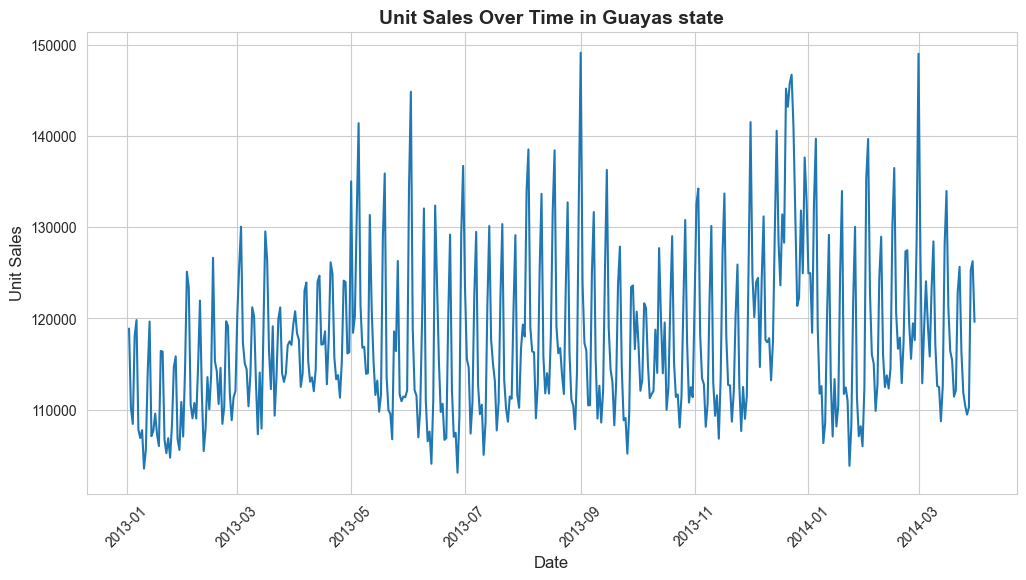

In [8]:
#Plotting the time-series, first with unit sales
plt.figure(figsize=(12, 6))
plt.plot(df_xg.index, df_xg["unit_sales"])
plt.title('Unit Sales Over Time in Guayas state', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Unit Sales', fontsize=12)
plt.xticks(fontsize=10, rotation=45)
plt.yticks(fontsize=10)
plt.show()

In [9]:
df_xg.isnull().sum()

unit_sales           0
onpromotion          0
unit_sales_log       0
is_outlier           0
year                 0
month                0
day                  0
day_of_week          0
unit_sales_7d_avg    6
is_holiday           0
dcoilwtico           0
dtype: int64

In [10]:
#Dropping nulls as they represent the first 6 days in the data
df_xg = df_xg.dropna(subset=['unit_sales_7d_avg'])

### Feature engineering

The performance of a machine learning model is heavily dependent on the quality of the features it is trained on. For our time series data, we can create a variety of features from the date index. These time-based features will help our model learn and capture trends, seasonality, and other time-dependent patterns.

We will create a function to extract the following features from the date:
* Day of the week
* Day of the month
* Day of the year
* Week of the year
* Month
* Year
* Quarter

In [11]:
#Creating lag features based on acf and pacf to help predict unit sales using past data
df_xg["lag_1"] = df_xg["unit_sales"].shift(1)
df_xg["lag_6"] = df_xg["unit_sales"].shift(6)
df_xg["lag_7"] = df_xg["unit_sales"].shift(7)
df_xg["lag_8"] = df_xg["unit_sales"].shift(8)
df_xg["lag_14"] = df_xg["unit_sales"].shift(14)

In [12]:
#Creating rolling standard deviation
df_xg["unit_sales_7d_std"] = df_xg["unit_sales"].rolling(window=7).std()

In [13]:
#Dropping any nulls created fom new features
df_xg.dropna(inplace=True)

In [14]:
df_xg.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 434 entries, 2013-01-22 to 2014-03-31
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   unit_sales         434 non-null    float64
 1   onpromotion        434 non-null    float64
 2   unit_sales_log     434 non-null    float64
 3   is_outlier         434 non-null    int64  
 4   year               434 non-null    int64  
 5   month              434 non-null    int64  
 6   day                434 non-null    int64  
 7   day_of_week        434 non-null    int64  
 8   unit_sales_7d_avg  434 non-null    float64
 9   is_holiday         434 non-null    int64  
 10  dcoilwtico         434 non-null    float64
 11  lag_1              434 non-null    float64
 12  lag_6              434 non-null    float64
 13  lag_7              434 non-null    float64
 14  lag_8              434 non-null    float64
 15  lag_14             434 non-null    float64
 16  unit_sa

In [15]:
#Saving csv for later use in forecasting app
df_xg.to_csv("/Users/dan/PycharmProjects/Masterschool/TimeSeriesRetailForecast/data/model_data.csv")

### XGBoost model

With our features engineered, we are now ready to train our XGBoost model. We will first define our feature set (the independent variables) and our target variable (what we want to predict).

Then, we will split our data into a training and a testing set. As before, we will use a date-based split to ensure that we are training on past data and testing on future data, which simulates a real-world forecasting scenario.

In [16]:
#Defining target and features
X = df_xg.drop(["unit_sales_log", "unit_sales"], axis=1)
y = df_xg["unit_sales_log"]

In [17]:
X.head()

,onpromotion,is_outlier,year,month,day,day_of_week,unit_sales_7d_avg,is_holiday,dcoilwtico,lag_1,lag_6,lag_7,lag_8,lag_14,unit_sales_7d_std
date,,,,,,,,,,,,,,,
2013-01-22,0.00,177,2013,1,22,1,5.28,0,96.09,"106,719.20","109,561.19","107,677.58","107,095.90","106,891.60","4,793.61"
2013-01-23,0.00,184,2013,1,23,2,5.26,0,95.06,"105,237.37","107,279.15","109,561.19","107,677.58","107,756.39","4,908.88"
2013-01-24,0.00,169,2013,1,24,3,5.24,0,95.35,"106,872.68","106,013.94","107,279.15","109,561.19","103,535.54","5,167.03"
2013-01-25,0.00,197,2013,1,25,4,5.26,0,95.15,"104,745.29","116,428.10","106,013.94","107,279.15","105,617.37","5,022.77"
2013-01-26,0.00,214,2013,1,26,5,5.24,0,95.15,"108,329.32","116,359.63","116,428.10","106,013.94","114,102.17","4,632.94"


In [18]:
y.head()

date
2013-01-22   1.39
2013-01-23   1.40
2013-01-24   1.39
2013-01-25   1.41
2013-01-26   1.44
Name: unit_sales_log, dtype: float64

In [19]:
#Splitting data into train test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print(X_train.shape)
print(X_test.shape)

(347, 15)
(87, 15)


In [20]:
#Initialising model
xg_model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, max_depth=5, learning_rate=0.1)

In [21]:
#Training model
xg_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

We have now trained our XGBoost regressor model on our training data. The `n_estimators` parameter controls the number of boosting rounds, and `learning_rate` controls the step size at each iteration. These are important hyperparameters that can be tuned to optimize model performance.

Next, we will use our trained model to make predictions on the test set and evaluate its performance.

In [22]:
#Converting y predict back to the original scale
y_pred_log = xg_model.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_test)

In [23]:
#Checking evaluation metrics
mae = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2 = r2_score(y_true, y_pred)

print(f"XGBoost MAE: {mae:.4f}")
print(f"XGBoost MAPE: {mape:.2f}%")
print(f"XGBoost R2 Score: {r2:.4f}")

XGBoost MAE: 0.0617
XGBoost MAPE: 1.83%
XGBoost R2 Score: 0.8087


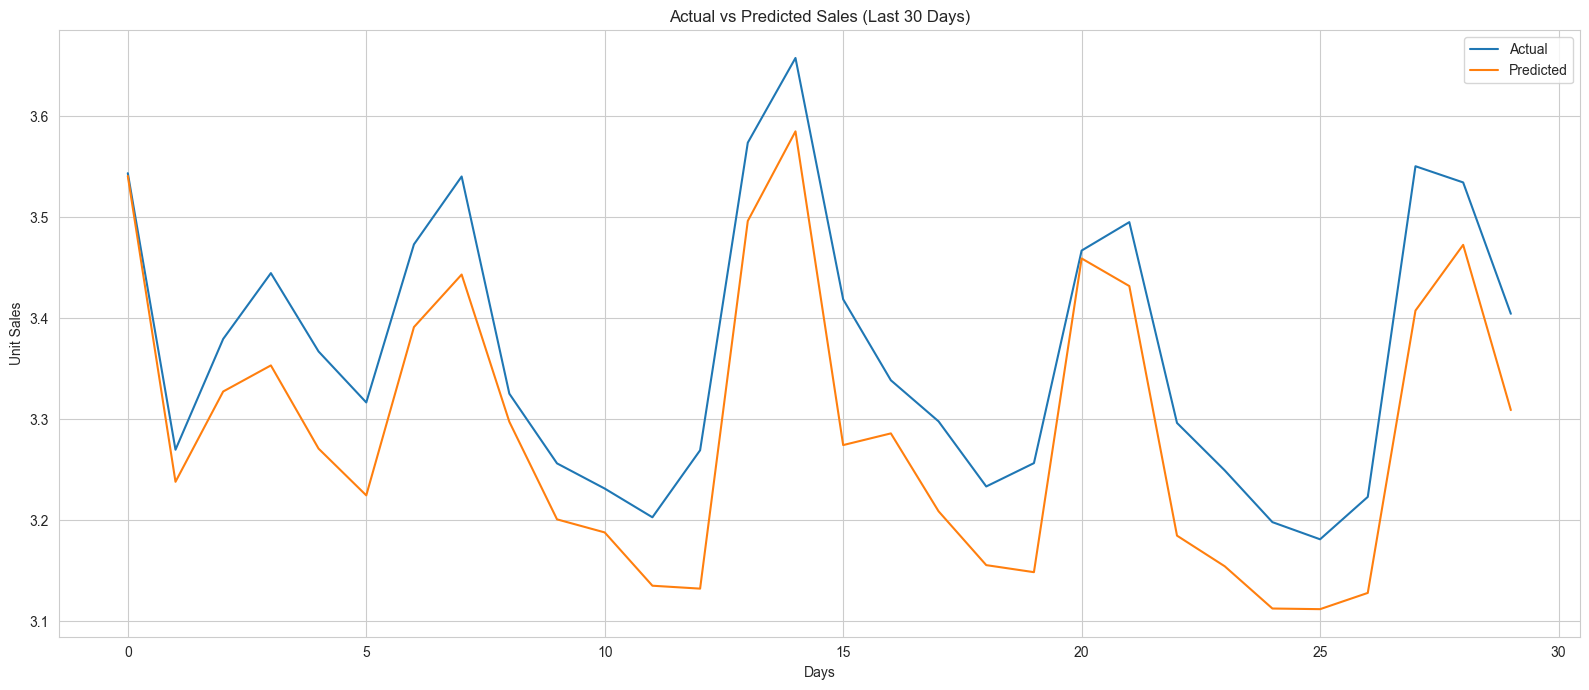

In [24]:
#PLotting time series for visual inspection
plt.figure(figsize=(16, 7))

plt.plot(pd.Series(y_true[-30:]).reset_index(drop=True), label="Actual", color='#1f77b4')
plt.plot(pd.Series(y_pred[-30:]).reset_index(drop=True), label="Predicted", color='#ff7f0e')
plt.title("Actual vs Predicted Sales (Last 30 Days)")
plt.xlabel("Days")
plt.ylabel("Unit Sales")
plt.legend()
plt.tight_layout()
plt.show()

XGBoost has achieved strong results with a low error rate and strong fit. The plot shows that in the last 30 days, the model is underpredicting slightly. I will now optimize with hyperparameter tuning to see if we can improve our model further.

### Hyperparameter tuning

In [25]:
#Creating a new variable for the next model
xgh_model = xgb.XGBRegressor(objective='reg:squarederror')

In [26]:
#Defining the parameter grid
param_grid = {
    "eta": [0.01, 0.05, 0.1, 0.2],
    "max_depth": [3, 5, 7],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "min_child_weight": [1, 5, 10],
    "gamma": [0, 0.1, 0.2],
    "n_estimators": [100, 200, 300],
    "reg_lambda": [0, 0.1, 1],
    "reg_alpha": [0, 0.1, 1],
}

In [27]:
#Time series split for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

In [28]:
#Randomized search with cv
random_search = RandomizedSearchCV(estimator=xgh_model,
                                   param_distributions=param_grid,
                                   cv=tscv,
                                   n_iter=10,
                                   scoring='neg_mean_squared_error')

In [29]:
#Fitting model and searching best parameters
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          feature_weights=None, gamm...
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None, ...),
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'eta': [0.01, 0.05, 0.1, 0.2],
                                        'gamma': [0, 0.1, 0.2],
                                        'max_depth': [3, 5, 7],
                                        'min_child_weight': [1, 5, 10],
                                        'n_estimators': [100, 200, 300],
                                        'reg_alpha': [0, 0.1, 1],
                                        'reg_lambda': [0, 0.1, 1],
                                        'subsample': [0.6, 0.8, 1.0]},
                   scoring='neg_mean_squared_error')

In [30]:
#Saving best parameters
best_params = random_search.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'subsample': 1.0, 'reg_lambda': 1, 'reg_alpha': 0.1, 'n_estimators': 300, 'min_child_weight': 10, 'max_depth': 3, 'gamma': 0, 'eta': 0.2, 'colsample_bytree': 1.0}


In [31]:
#Saving the model
best_model = random_search.best_estimator_

In [32]:
#Converting y pred back to the original scale
y_pred_log = best_model.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_test)

In [33]:
#Evaluating the model
mae = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2 = r2_score(y_true, y_pred)

print(f"Tuned XGBoost MAE: {mae:.4f}")
print(f"Tuned XGBoost MAPE: {mape:.2f}%")
print(f"Tuned XGBoost R2 Score: {r2:.4f}")

Tuned XGBoost MAE: 0.0562
Tuned XGBoost MAPE: 1.66%
Tuned XGBoost R2 Score: 0.8379


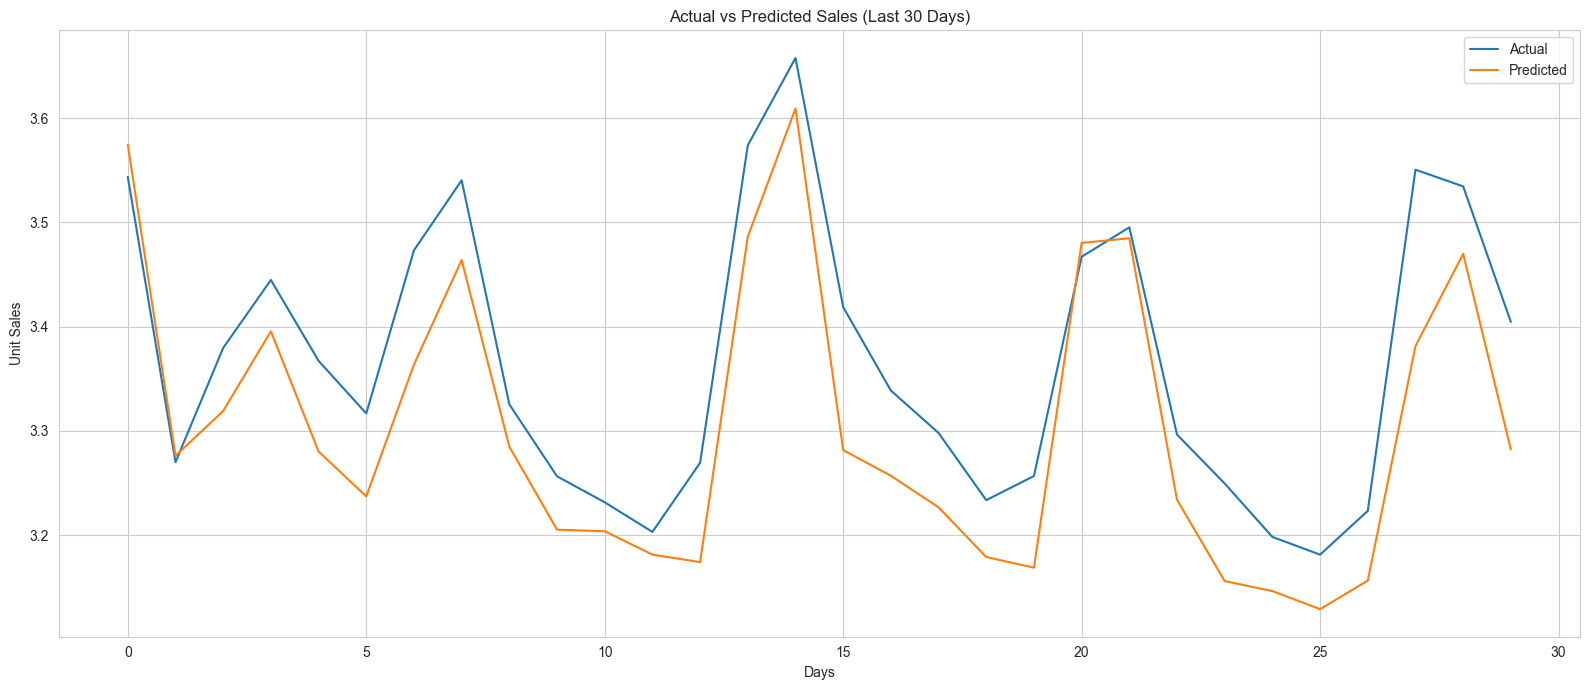

In [34]:
#Visualy inspecting the forecast
plt.figure(figsize=(16, 7))

plt.plot(pd.Series(y_true[-30:]).reset_index(drop=True), label="Actual", color='#1f77b4')
plt.plot(pd.Series(y_pred[-30:]).reset_index(drop=True), label="Predicted", color='#ff7f0e')
plt.title("Actual vs Predicted Sales (Last 30 Days)")
plt.xlabel("Days")
plt.ylabel("Unit Sales")
plt.legend()
plt.tight_layout()
plt.show()

One of the advantages of tree-based models like XGBoost is that they can provide us with an estimate of the importance of each feature in the model. This is a valuable insight as it helps us understand which factors are the most influential in predicting sales.

The plot below shows the feature importance scores from our trained model. A higher score indicates that the feature is more important for the model's predictions.

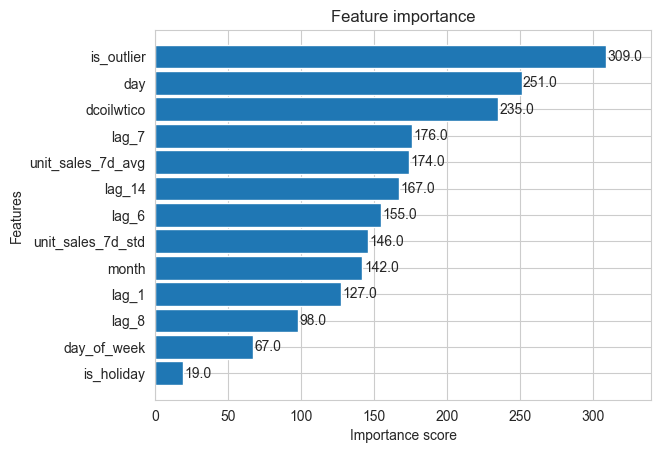

In [35]:
#Reviewing most important features
plot_importance(xg_model, height=0.9);

In [36]:
#Initializing model with best params
xgh_model = xgb.XGBRegressor(objective="reg:squarederror",
                             subsample=1,
                             reg_lambda=0,
                             reg_alpha=0,
                             n_estimators=300,
                             min_child_weight=1,
                             max_depth=3,
                             gamma=0,
                             eta=0.2,
                             colsample_bytree=0.6,
                             learning_rate=0.1)


In [37]:
#Training model with best params
xgh_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.2, eval_metric=None,
             feature_types=None, feature_weights=None, gamma=0,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None, ...)

### Saving the Final Model

Now that we have trained and evaluated our final model, we will save it to a file using `pickle`. This will allow us to easily load and use our trained model in the future without having to retrain it every time. This is especially useful for deploying the model in a production environment or for making future predictions.

In [38]:
#Saving the model for future use
import pickle
import os

#defining a location to save the model
pickle_dir = "/Users/dan/PycharmProjects/Masterschool/TimeSeriesRetailForecast/models"
model_filename = "xgh_model.pkl" # Choose a filename for your model

#Constructing the full file path
pickle_path = os.path.join(pickle_dir, model_filename)

#Saving the best model
with open(pickle_path, 'wb') as f:
    pickle.dump(xgh_model, f)

print(f"model saved as pickle file at: {pickle_path}")

model saved as pickle file at: /Users/dan/PycharmProjects/Masterschool/TimeSeriesRetailForecast/models/xgh_model.pkl


In [39]:
#Loading saved model
with open(pickle_path, 'rb') as f:
    xgh_model = pickle.load(f)